This notebook runs through the code necessary to predict protein structures with ESMFold, generate distance maps, and intialize graph networks based on those structures

In [ ]:
#import some packages here
import networkx as nx
import py3Dmol
import numpy as np
import torch
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser

In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("protein_folding_notebook", framework="pytorch")

from transformers import AutoTokenizer, EsmForProteinFolding

# Load tokenizer and model
model_name = "facebook/esmfold_v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForProteinFolding.from_pretrained(model_name, low_cpu_mem_usage=True).cuda()

# Uncomment to switch the stem to float16 for memory optimization
model.esm = model.esm.half()

# Enable TensorFloat32 for faster matrix multiplications
torch.backends.cuda.matmul.allow_tf32 = True

# Set chunk size optimized for an 11GB GPU
model.trunk.set_chunk_size(128)

# Define the protein sequence
test_protein = (
    "METVAYADFARLEMRVGKIVEVKRHENADKLYIVQVDVGQKTLQTVTSLVPYYSEEELMGKTVVVLCNLQKAKMRGETSECMLLCAETDDGSESVLLTPERMMPAGVRVV"
)

# Tokenize input
input_ids = tokenizer([test_protein], return_tensors="pt", add_special_tokens=False)['input_ids'].cuda()

/root/miniconda3/envs/esm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Predict protein structure
with torch.no_grad():
    outputs = model(input_ids)

In [ ]:
# Helper functions for PDB conversion
from transformers.models.esm.openfold_utils.protein import to_pdb, Protein as OFProtein
from transformers.models.esm.openfold_utils.feats import atom14_to_atom37

def convert_outputs_to_pdb(outputs):
    # Directly convert tensor outputs to numpy
    final_atom_positions = atom14_to_atom37(outputs["positions"][-1], outputs)
    final_atom_positions_np = final_atom_positions.cpu().numpy()
    final_atom_mask = outputs["atom37_atom_exists"].cpu().numpy()

    pdbs = []
    for i in range(outputs["aatype"].shape[0]):
        aa = outputs["aatype"][i].cpu().numpy()
        pred_pos = final_atom_positions_np[i]
        mask = final_atom_mask[i]
        resid = outputs["residue_index"][i].cpu().numpy() + 1
        pred = OFProtein(
            aatype=aa,
            atom_positions=pred_pos,
            atom_mask=mask,
            residue_index=resid,
            b_factors=outputs["plddt"][i].cpu().numpy(),
            chain_index=outputs["chain_index"][i].cpu().numpy()
            if "chain_index" in outputs
            else None,
        )
        pdbs.append(to_pdb(pred))
    return pdbs

# Convert to PDB
pdbs = convert_outputs_to_pdb(outputs)

# Save PDBs or further process 
for idx, pdb in enumerate(pdbs):
    with open(f"predicted_structure_{idx + 1}.pdb", "w") as f:
        f.write(pdb)

print("PDB structures generated and saved.")

PDB structures generated and saved.


In [ ]:
def view_pdb_structure(pdb_file):
    """
    Function to visualize a PDB structure using py3Dmol.
    
    Parameters:
        pdb_file (str): Path to the PDB file to visualize.
    """
    with open(pdb_file, 'r') as f:
        pdb_data = f.read()

    # Create a py3Dmol viewer instance
    view = py3Dmol.view()
    view.addModel(pdb_data, "pdb")  # Add PDB data to the viewer
    view.setStyle({"cartoon": {"color": "spectrum"}})  # Apply cartoon style
    view.zoomTo()  # Adjust view to fit the structure

    return view

pdb_file = "predicted_structure_1.pdb"  # Replace with path later
view = view_pdb_structure(pdb_file)
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

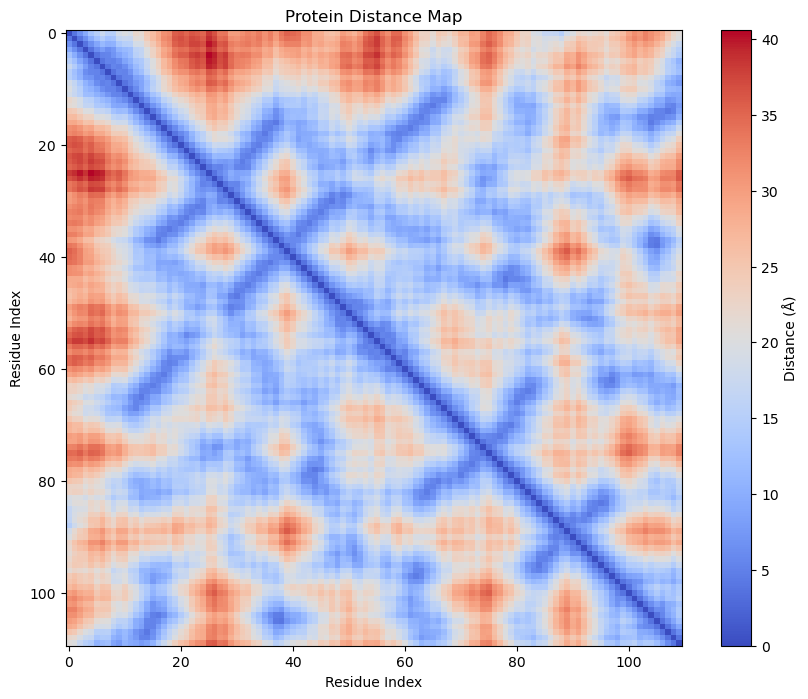

Distance map generated and displayed.


In [ ]:
# Function to calculate the distance map
def calculate_distance_map(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)

    # Extract α-carbon (CA) coordinates
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    ca_atoms.append(residue['CA'].coord)

    ca_atoms = np.array(ca_atoms)

    # Calculate pairwise distances
    distance_map = np.sqrt(((ca_atoms[:, None, :] - ca_atoms[None, :, :]) ** 2).sum(axis=-1))
    return distance_map

# Function to plot the distance map
def plot_distance_map(distance_map):
    plt.figure(figsize=(10, 8))
    plt.imshow(distance_map, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Distance (Å)')
    plt.title('Protein Distance Map')
    plt.xlabel('Residue Index')
    plt.ylabel('Residue Index')
    plt.show()

# Load and process the first PDB file
distance_map = calculate_distance_map("predicted_structure_1.pdb")

# Display the distance map
plot_distance_map(distance_map)

print("Distance map generated and displayed.")


In [ ]:
# Function to initialize the graph representation where all nodes are displayed 
def initialize_graph(distance_map, threshold):
    G = nx.Graph()
    num_residues = distance_map.shape[0]

    # Add nodes for each residue
    for i in range(num_residues):
        G.add_node(i, label=f'Residue {i+1}')

    # Add edges based on the distance threshold
    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            if distance_map[i, j] < threshold:
                G.add_edge(i, j, weight=distance_map[i, j])

    return G

# Function to visualize the graph using py3Dmol
def visualize_graph_3d(protein_graph, ca_coords):
    view = py3Dmol.view()

    # Add nodes
    for node in protein_graph.nodes:
        coord = ca_coords[node]
        view.addSphere({
            "center": {"x": coord[0], "y": coord[1], "z": coord[2]},
            "radius": 0.2,
            "color": "blue",
        })

    # Add edges
    for edge in protein_graph.edges:
        coord1 = ca_coords[edge[0]]
        coord2 = ca_coords[edge[1]]
        view.addCylinder({
            "start": {"x": coord1[0], "y": coord1[1], "z": coord1[2]},
            "end": {"x": coord2[0], "y": coord2[1], "z": coord2[2]},
            "radius": 0.01,
            "color": "red",
        })

    view.zoomTo()
    return view

# Generate example CA coordinates for visualization (replace with actual CA coordinates from PDB parsing)
def extract_ca_coordinates(distance_map):
    num_residues = distance_map.shape[0]
    # Example: random 3D coordinates
    np.random.seed(42)
    ca_coords = np.random.rand(num_residues, 3) * 10
    return ca_coords

# Replace with actual distance map and CA coordinates
distance_map = np.random.rand(50, 50) * 15  # Example random distance map
ca_coords = extract_ca_coordinates(distance_map)

# Initialize the graph with a threshold in angstroms
threshold = 12.0
protein_graph = initialize_graph(distance_map, threshold)

# Visualize the graph
view = visualize_graph_3d(protein_graph, ca_coords)
view.show()

print(f"Graph initialized with {protein_graph.number_of_nodes()} nodes and {protein_graph.number_of_edges()} edges.")


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Graph initialized with 50 nodes and 983 edges.


In [ ]:
# Function to initialize the graph representation where only nodes within the threshold are displayed
def initialize_graph(distance_map, threshold):
    G = nx.Graph()
    num_residues = distance_map.shape[0]

    # Add nodes for each residue
    for i in range(num_residues):
        G.add_node(i, label=f'Residue {i+1}')

    # Add edges based on the distance threshold
    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            if distance_map[i, j] < threshold:
                G.add_edge(i, j, weight=distance_map[i, j])

    return G

# Function to visualize the graph using py3Dmol
def visualize_graph_3d(protein_graph, ca_coords):
    view = py3Dmol.view()

    # Add nodes
    for node in protein_graph.nodes:
        coord = ca_coords[node]
        view.addSphere({
            "center": {"x": coord[0], "y": coord[1], "z": coord[2]},
            "radius": 0.1,
            "color": "blue",
        })

    # Add edges
    for edge in protein_graph.edges:
        coord1 = ca_coords[edge[0]]
        coord2 = ca_coords[edge[1]]
        if np.linalg.norm(coord1 - coord2) <= threshold:  # Add only edges within the threshold
            view.addCylinder({
                "start": {"x": coord1[0], "y": coord1[1], "z": coord1[2]},
                "end": {"x": coord2[0], "y": coord2[1], "z": coord2[2]},
                "radius": 0.05,
                "color": "red",
            })

    view.zoomTo()
    return view

# Generate example CA coordinates for visualization (replace with actual CA coordinates from PDB parsing)
def extract_ca_coordinates(distance_map):
    num_residues = distance_map.shape[0]
    np.random.seed(42)
    ca_coords = np.random.rand(num_residues, 3) * 10
    return ca_coords

# Replace with actual distance map and CA coordinates
distance_map = np.random.rand(50, 50) * 15  # Example random distance map
ca_coords = extract_ca_coordinates(distance_map)

# Initialize the graph with a threshold in angstroms
threshold = 6.0
protein_graph = initialize_graph(distance_map, threshold)

# Visualize the graph
view = visualize_graph_3d(protein_graph, ca_coords)
view.show()

print(f"Graph initialized with {protein_graph.number_of_nodes()} nodes and {protein_graph.number_of_edges()} edges.")


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Graph initialized with 50 nodes and 499 edges.
